# RAG12000 Dataset: Advanced K-Means Clustering & Analysis

This notebook performs K-Means clustering on the RAG12000 dataset.
It features:
- Modularized processing steps.
- Detailed visualization of Silhouette scores.
- 3D SVD visualization of document clusters.
- Graphical bar charts for top terms in **every** cluster.
- Comparative analysis for "questions":
    1. Fully preprocessed text (stopwords & corpus-specific common words removed).
    2. Partially preprocessed text (only stopwords removed).

## 1. Setup: Libraries and NLTK

In [ ]:
#!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import re
from collections import Counter

# Hugging Face Datasets
from datasets import load_dataset

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Scikit-learn for ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Plotting Style
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [ ]:
# NLTK Downloads
for resource, name in [('corpora/stopwords', 'stopwords'),
                       ('corpora/wordnet', 'wordnet'),
                       ('corpora/omw-1.4', 'omw-1.4'),
                       ('tokenizers/punkt', 'punkt')]:
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(name, quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words_english = set(stopwords.words('english'))

In [ ]:
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', quiet=True)

## 2. Load RAG12000 Dataset

In [ ]:
from datasets import load_dataset, concatenate_datasets, Dataset


Dataset.shape = property(lambda self: (self.num_rows, len(self.column_names)))

DATASET_NAME = "neural-bridge/rag-dataset-12000"
MAX_SAMPLES = None  # or set to an int, e.g. 1000

if MAX_SAMPLES:
    # Load first MAX_SAMPLES examples from train and from test, then merge
    ds_train = load_dataset(DATASET_NAME, split=f"train[:{MAX_SAMPLES}]")
    ds_test  = load_dataset(DATASET_NAME, split=f"test[:{MAX_SAMPLES}]")
    dataset_hf = concatenate_datasets([ds_train, ds_test])
else:
    # Load the entire train+test in one go
    dataset_hf = load_dataset(DATASET_NAME, split="train+test")

print(f"Unified dataset shape: {dataset_hf.shape}")  # -> (12000, 3) when MAX_SAMPLES is None



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

(…)-00000-of-00001-9df3a936e1f63191.parquet:   0%|          | 0.00/23.1M [00:00<?, ?B/s]

(…)-00000-of-00001-af2a9f454ad1b8a3.parquet:   0%|          | 0.00/5.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

Unified dataset shape: (12000, 3)


## 3. Core Processing Functions
  
  Cleans, tokenizes, and optionally lemmatizes and removes stopwords.
   It Returns: 1) processed_texts_joined: List of strings (joined tokens) for TF-IDF. 2) original_texts_for_clustering: Corresponding original texts for valid processed entries. 3) corpus_specific_stopwords_found: Set of corpus-specific stopwords (if removed).
    

### 3.1 Text Preprocessing

In [ ]:
def preprocess_text_data(texts_list_original, field_name_for_log,
                         apply_lemmatization=True,
                         remove_nltk_stopwords=True,
                         remove_corpus_specific_stopwords=True,
                         top_n_corpus_common_words=15):

    print(f"[Preprocessing - {field_name_for_log}] Starting...")
    if not texts_list_original: return [], [], set()

    texts_cleaned = [str(text).lower() if text is not None else "" for text in texts_list_original]
    texts_cleaned = [re.sub(r'[^a-z0-9\s]', '', text) for text in texts_cleaned]

    all_processed = []
    for text in texts_cleaned:
        tokens = word_tokenize(text)
        proc = []
        for token in tokens:
            if token.isalnum() and len(token) > 2:
                if remove_nltk_stopwords and token in stop_words_english:
                    continue
                if apply_lemmatization:
                    token = lemmatizer.lemmatize(token)
                proc.append(token)
        all_processed.append(proc)

    corpus_specific = set()
    if remove_corpus_specific_stopwords:
        flat = [t for sub in all_processed for t in sub]
        if flat:
            counts = Counter(flat)
            common = counts.most_common(top_n_corpus_common_words)
            corpus_specific = set([w for w,_ in common])
            print(f"  Found corpus-specific stopwords: {corpus_specific}")
            all_processed = [[t for t in doc if t not in corpus_specific] for doc in all_processed]

    processed_texts_joined = []
    original_texts_for_clustering = []
    for i, tokens in enumerate(all_processed):
        if tokens:
            processed_texts_joined.append(" ".join(tokens))
            original_texts_for_clustering.append(texts_list_original[i])
    print(f"[Preprocessing - {field_name_for_log}] Done. {len(processed_texts_joined)} docs remain.")
    return processed_texts_joined, original_texts_for_clustering, corpus_specific

### TF-IDF Vectorization Function

Defines `vectorize_with_tfidf`, which takes preprocessed text strings and parameters (`max_df`, `min_df`, `max_features`) to:
- Fit a `TfidfVectorizer` on the corpus  
- Print progress and resulting matrix shape  
- Return the TF-IDF matrix, vectorizer instance, and feature names (or `None` on error)


In [ ]:
def vectorize_with_tfidf(processed_texts_joined, field_name_for_log,
                         max_df=0.90, min_df=3, max_features=5000):
    print(f"[TF-IDF - {field_name_for_log}] Vectorizing...")
    if not processed_texts_joined:
        print("  No texts to vectorize.")
        return None, None, None
    vec = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features)
    try:
        mat = vec.fit_transform(processed_texts_joined)
        names = vec.get_feature_names_out()
        print(f"  TF-IDF matrix shape: {mat.shape}")
        return mat, vec, names
    except ValueError as e:
        print(f"  TF-IDF Error: {e}")
        return None, None, None

### Determining the Optimal Number of Clusters

This function evaluates KMeans clustering over a specified range of k values by computing silhouette scores for each, prints and highlights the best k on a plot of score versus k, and returns the optimal k along with its silhouette score (or error codes if it cannot be determined).

> Aggiungi citazione



In [ ]:
def find_optimal_k_silhouette(tfidf_matrix, k_range_to_test, field_name_for_log):
    print(f"[Optimal K - {field_name_for_log}] Finding optimal k...")
    if tfidf_matrix is None or tfidf_matrix.shape[0] < 2:
        print("  Not enough samples.")
        return -1, -2
    max_k = tfidf_matrix.shape[0] - 1
    ks = [k for k in k_range_to_test if 2 <= k < max_k]
    scores, best, best_score = [], -1, -2
    for k in ks:
        try:
            km = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='lloyd')
            lbl = km.fit_predict(tfidf_matrix)
            if len(set(lbl)) < 2:
                sc = -1
            else:
                sc = silhouette_score(tfidf_matrix, lbl)
            scores.append(sc)
            if sc > best_score:
                best_score, best = sc, k
        except:
            scores.append(-1)
    if best == -1:
        print("  Could not determine optimal k.")
        return -1, -2
    print(f"  Optimal k = {best} (Score: {best_score:.4f})")
    plt.figure(figsize=(10,6))
    plt.plot(ks, scores, marker='o')
    plt.axvline(best, color='red', linestyle='--')
    plt.title(f'Silhouette Score vs k for {field_name_for_log}')
    plt.xlabel('k'); plt.ylabel('Score'); plt.grid(True); plt.show()
    return best, best_score



### K-Means Clustering

Performs K-Means on the TF-IDF matrix using the specified number of clusters, prints the resulting inertia, and returns the fitted model and cluster labels.


In [ ]:
def perform_kmeans_clustering(tfidf_matrix, num_clusters, field_name_for_log):
    print(f"[K-Means - {field_name_for_log}] Clustering with k={num_clusters}...")
    if tfidf_matrix is None or num_clusters <= 0:
        print("  Invalid input.")
        return None, None
    km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto', algorithm='lloyd')
    lbl = km.fit_predict(tfidf_matrix)
    print(f"  Inertia: {km.inertia_:.2f}")
    return km, lbl

### Cluster Analysis and Visualization

This section provides helper functions to inspect and visualize clustering results:
- **`display_cluster_top_terms_textual`**: Prints the top terms for each cluster from the KMeans centroids.
- **`plot_cluster_top_terms_graphical`**: Shows bar charts of the top terms per cluster using Seaborn.
- **`plot_clusters_3d_svd`**: Reduces TF-IDF vectors to 3D via SVD and visualizes clusters in a scatter plot.





In [ ]:
import plotly.express as px

def display_cluster_top_terms_textual(kmodel, fnames, k, label, top_n=10):
    print(f"\n--- Top Terms per Cluster for {label} (k={k}) ---")
    order = kmodel.cluster_centers_.argsort()[:, ::-1]
    for i in range(k):
        terms = [fnames[idx] for idx in order[i, :top_n]]
        print(f"Cluster {i}: {', '.join(terms)}")

def plot_cluster_top_terms_graphical(kmodel, fnames, k, label, top_n=8, cols=2):
    print(f"\n--- Graphical Top Terms for {label} ---")
    order = kmodel.cluster_centers_.argsort()[:, ::-1]
    rows = (k + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 5*rows), squeeze=False)
    palette = sns.color_palette("viridis", top_n)
    for i in range(k):
        ax = axs.flatten()[i]
        idxs = order[i, :top_n]
        terms = [fnames[j] for j in idxs]
        weights = kmodel.cluster_centers_[i, idxs]
        ax.barh(terms[::-1], weights[::-1], color=palette)
        ax.set_title(f"Cluster {i}")
    for j in range(k, rows*cols):
        fig.delaxes(axs.flatten()[j])
    plt.suptitle(f"Top {top_n} Terms per Cluster for {label}", y=1.02)
    plt.tight_layout()
    plt.show()

def plot_clusters_3d_svd(tfidf_matrix, lbls, k, label):
    print(f"\n--- 3D SVD Interactive Visualization for {label} ---")
    # Riduci a 3 dimensioni
    svd = TruncatedSVD(n_components=3, random_state=42)
    red = svd.fit_transform(tfidf_matrix)


    import pandas as pd
    df3d = pd.DataFrame(red, columns=['x','y','z'])
    df3d['cluster'] = lbls.astype(str)

    # Crea scatter 3D interattivo
    fig = px.scatter_3d(
        df3d, x='x', y='y', z='z',
        color='cluster',
        title=f'3D SVD of {label}',
        labels={'x':'Component 1','y':'Component 2','z':'Component 3'},
        opacity=0.7
    )
    fig.update_traces(marker=dict(size=4))
    fig.show()

### Orchestrating the Full Clustering Pipeline

The `run_clustering_pipeline` function takes raw text inputs and a label flag, then:

1. Preprocesses the text (with optional corpus-specific stopword removal)  
2. Computes a TF-IDF representation  
3. Determines the optimal number of clusters via silhouette analysis  
4. Runs K-Means clustering with the chosen k  
5. Displays top terms per cluster both textually and graphically  
6. Produces a 3D SVD plot of the resulting clusters  

Each step includes early exits on invalid or empty data to ensure robustness.  


In [ ]:
def run_clustering_pipeline(texts, label, remove_corpus=True):
    print(f"\n{'='*80}\nProcessing: {label} | Remove Corpus-Specific: {remove_corpus}\n{'='*80}")
    proc, origs, corp = preprocess_text_data(texts, label, remove_corpus_specific_stopwords=remove_corpus)
    if not proc: return
    mat, vec, fnames = vectorize_with_tfidf(proc, label)
    if mat is None: return
    best_k, _ = find_optimal_k_silhouette(mat, range(2,11), label)
    if best_k <= 0: return
    kmodel, lbls = perform_kmeans_clustering(mat, best_k, label)
    display_cluster_top_terms_textual(kmodel, fnames, best_k, label)
    plot_cluster_top_terms_graphical(kmodel, fnames, best_k, label)
    plot_clusters_3d_svd(mat, lbls, best_k, label)

## 5. Analysis: Document Contexts


Processing: Document Contexts | Remove Corpus-Specific: True
[Preprocessing - Document Contexts] Starting...
  Found corpus-specific stopwords: {'also', 'year', 'said', 'like', 'would', 'make', 'need', 'people', 'day', 'new', 'time', 'one', 'first', 'work', 'get'}
[Preprocessing - Document Contexts] Done. 12000 docs remain.
[TF-IDF - Document Contexts] Vectorizing...
  TF-IDF matrix shape: (12000, 5000)
[Optimal K - Document Contexts] Finding optimal k...
  Optimal k = 10 (Score: 0.0065)


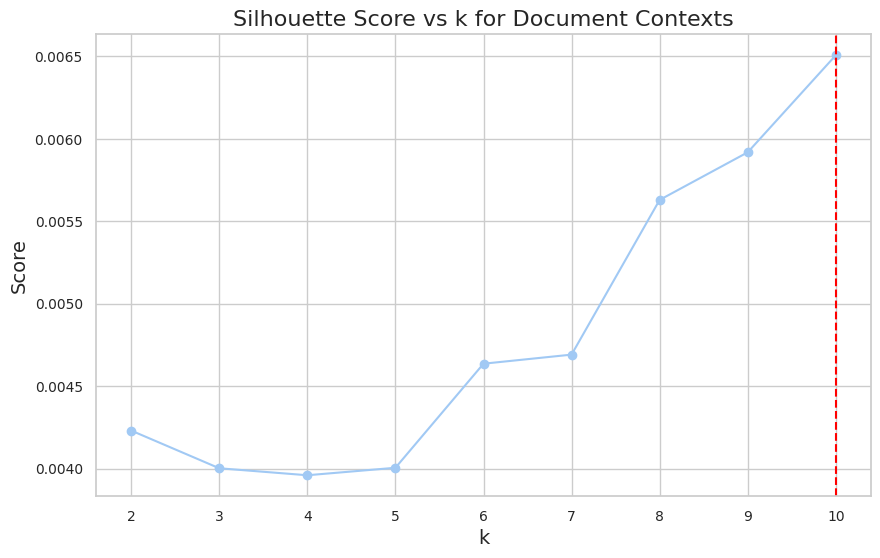

[K-Means - Document Contexts] Clustering with k=10...
  Inertia: 11370.57

--- Top Terms per Cluster for Document Contexts (k=10) ---
Cluster 0: health, patient, insurance, medical, care, treatment, disease, hospital, doctor, cancer
Cluster 1: product, price, car, water, design, use, model, plant, power, energy
Cluster 2: data, user, file, use, site, software, website, server, information, window
Cluster 3: food, recipe, cup, cheese, chicken, restaurant, ingredient, add, dish, pepper
Cluster 4: business, company, market, customer, service, sale, marketing, product, industry, loan
Cluster 5: student, school, state, law, university, president, government, court, police, community
Cluster 6: hotel, room, bedroom, bed, bath, property, guest, sqft, parking, area
Cluster 7: game, team, season, player, play, league, win, coach, point, goal
Cluster 8: love, know, thing, dont, think, really, book, life, good, want
Cluster 9: music, film, art, show, event, city, world, song, artist, movie

--- G

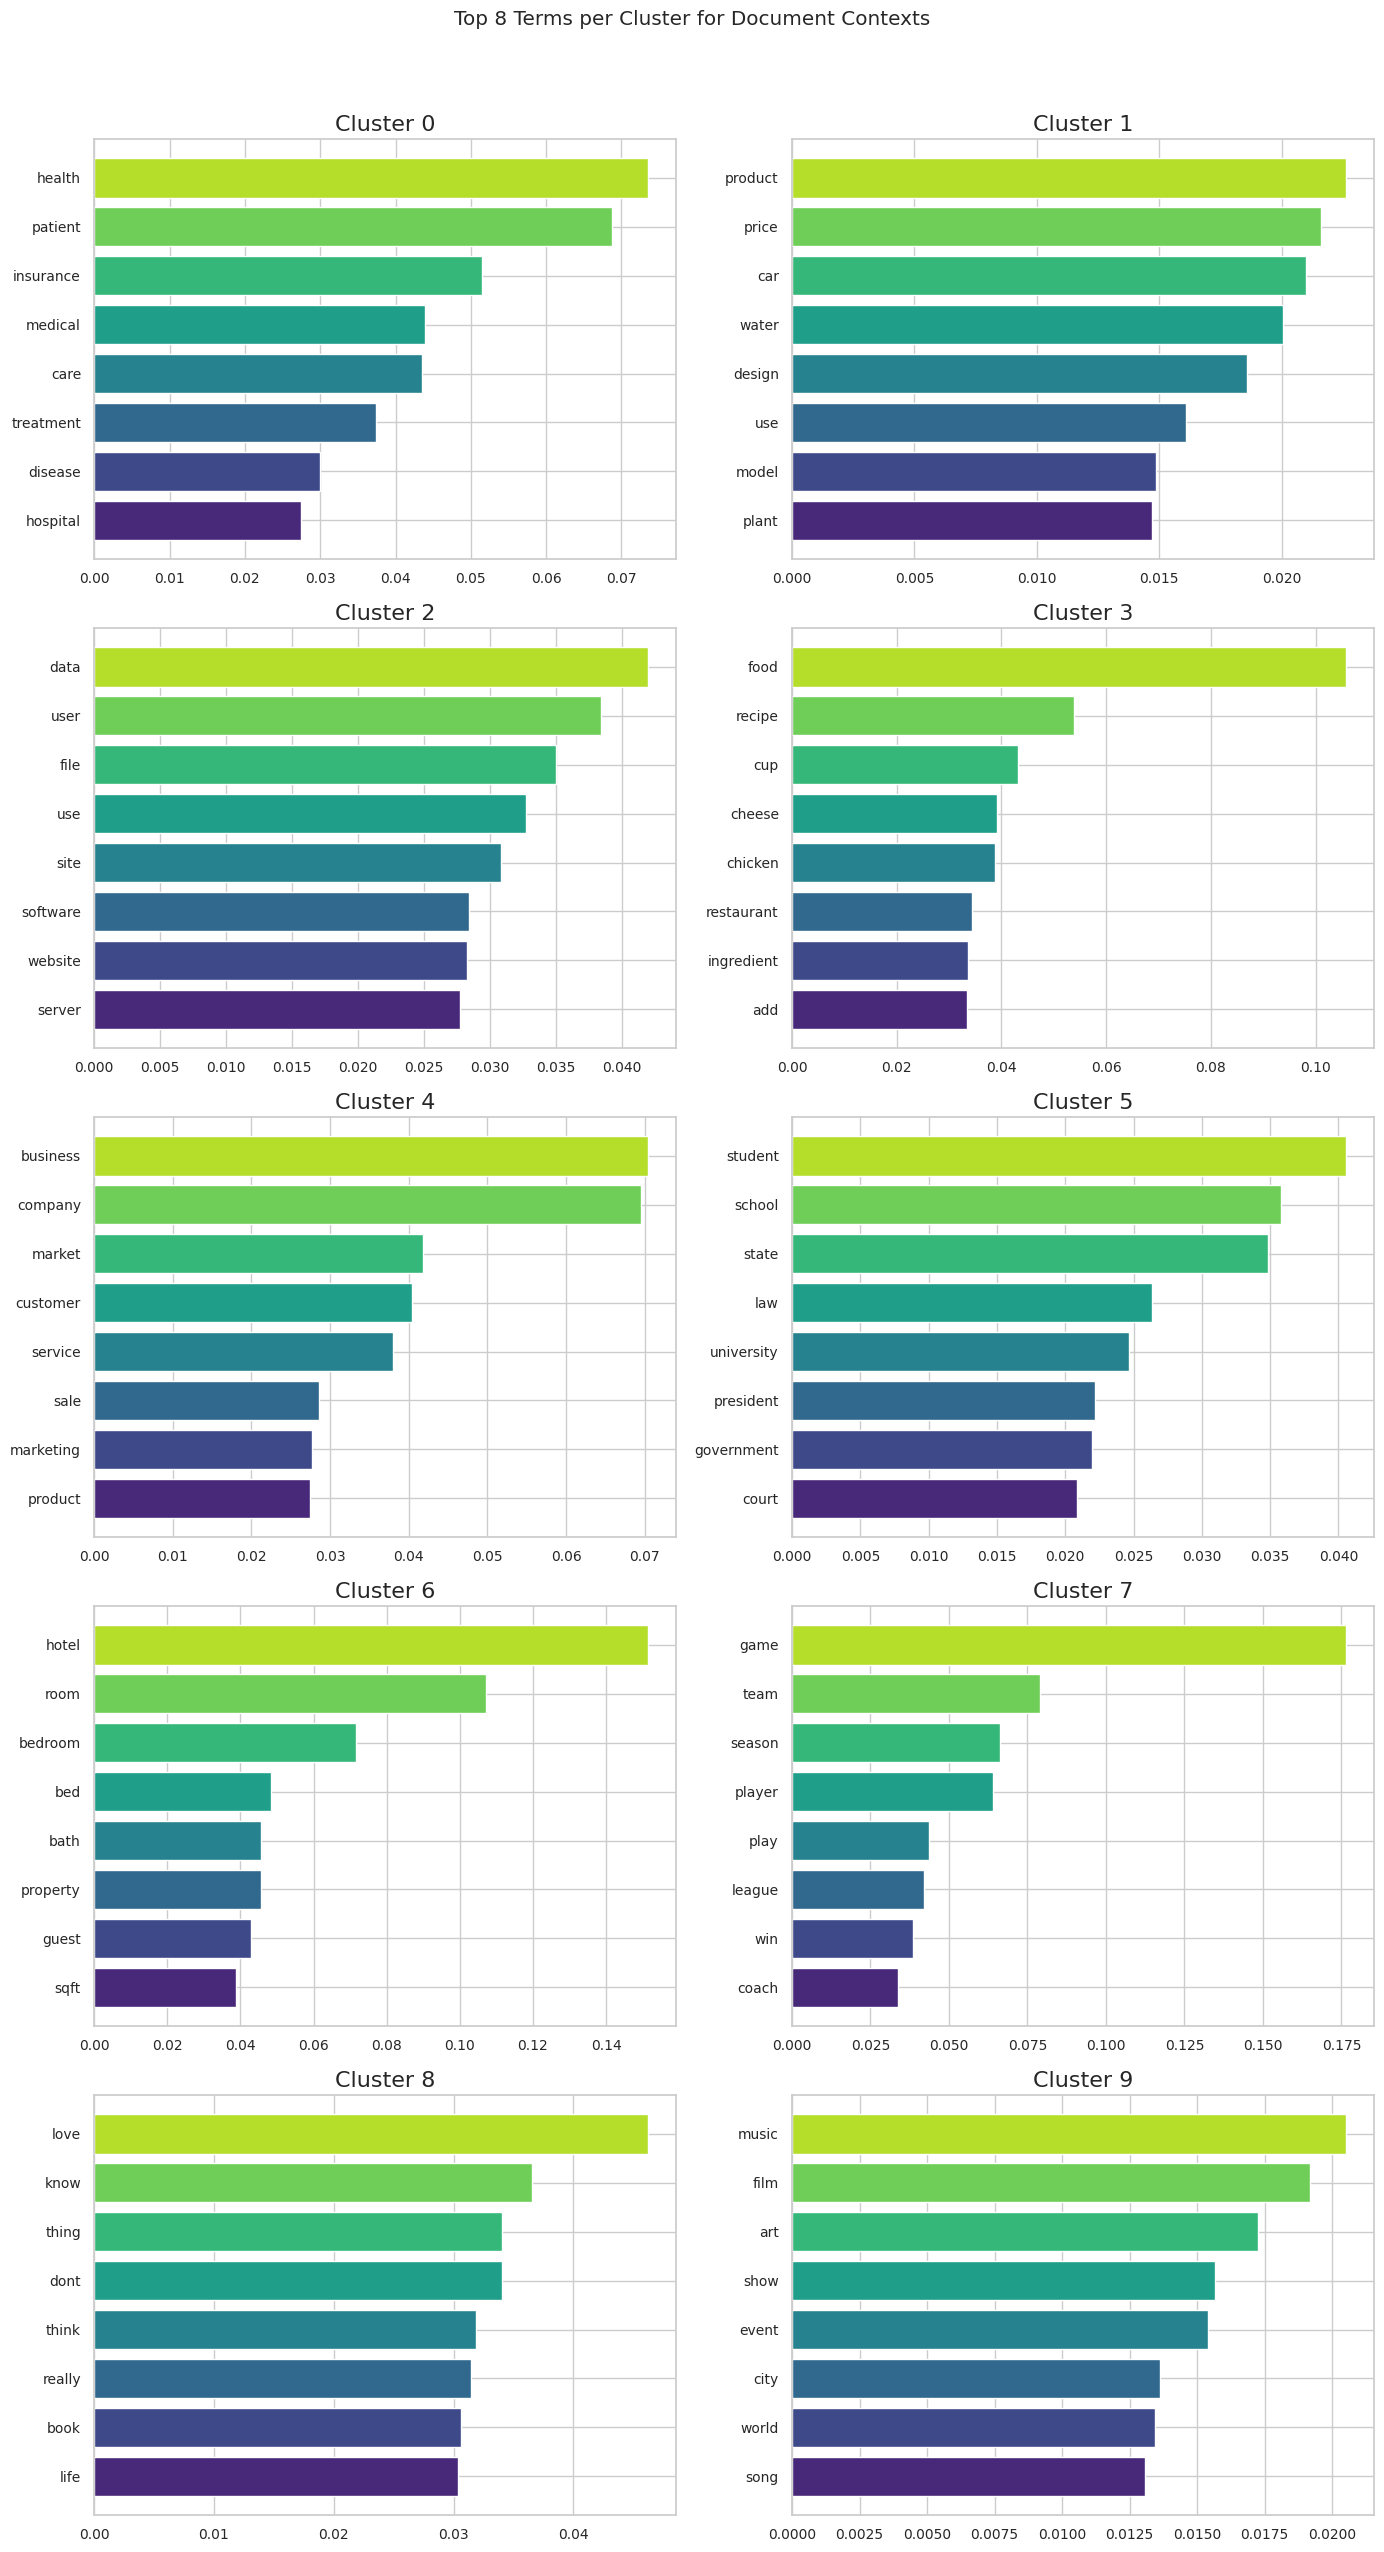


--- 3D SVD Interactive Visualization for Document Contexts ---


In [ ]:
if dataset_hf:
    run_clustering_pipeline(dataset_hf["context"], "Document Contexts", remove_corpus=True)
else:
    print("Dataset not loaded")


### Comparing Clustering on Minimally vs Fully Processed Questions

This section runs the clustering pipeline twice on the `question` column to compare the impact of preprocessing:
- **NLTK Only**: removes only standard NLTK stopwords  
- **Fully Processed**: applies additional corpus-specific stopword removal and cleaning  






Processing: Questions (NLTK Only) | Remove Corpus-Specific: False
[Preprocessing - Questions (NLTK Only)] Starting...
[Preprocessing - Questions (NLTK Only)] Done. 11997 docs remain.
[TF-IDF - Questions (NLTK Only)] Vectorizing...
  TF-IDF matrix shape: (11997, 4561)
[Optimal K - Questions (NLTK Only)] Finding optimal k...
  Optimal k = 10 (Score: 0.0108)


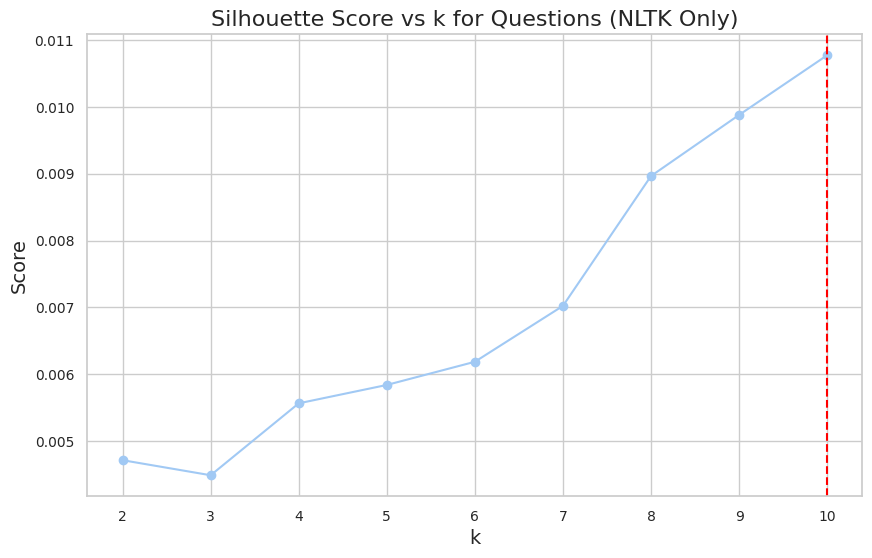

[K-Means - Questions (NLTK Only)] Clustering with k=10...
  Inertia: 11590.86

--- Top Terms per Cluster for Questions (NLTK Only) (k=10) ---
Cluster 0: first, game, step, season, quarter, author, scored, book, time, woman
Cluster 1: context, mentioned, according, main, described, two, discussed, one, type, feature
Cluster 2: author, main, feature, according, two, used, book, game, event, role
Cluster 3: day, activity, valentine, first, context, school, author, theme, international, celebrated
Cluster 4: amenity, offer, hotel, provided, guest, offered, available, house, inn, apartment
Cluster 5: service, offered, provide, offer, provided, company, context, mentioned, main, product
Cluster 6: purpose, main, program, context, according, project, using, initiative, website, tool
Cluster 7: business, challenge, faced, small, according, face, three, model, system, strategy
Cluster 8: new, york, feature, year, zealand, according, introduced, author, launched, name
Cluster 9: benefit, using, 

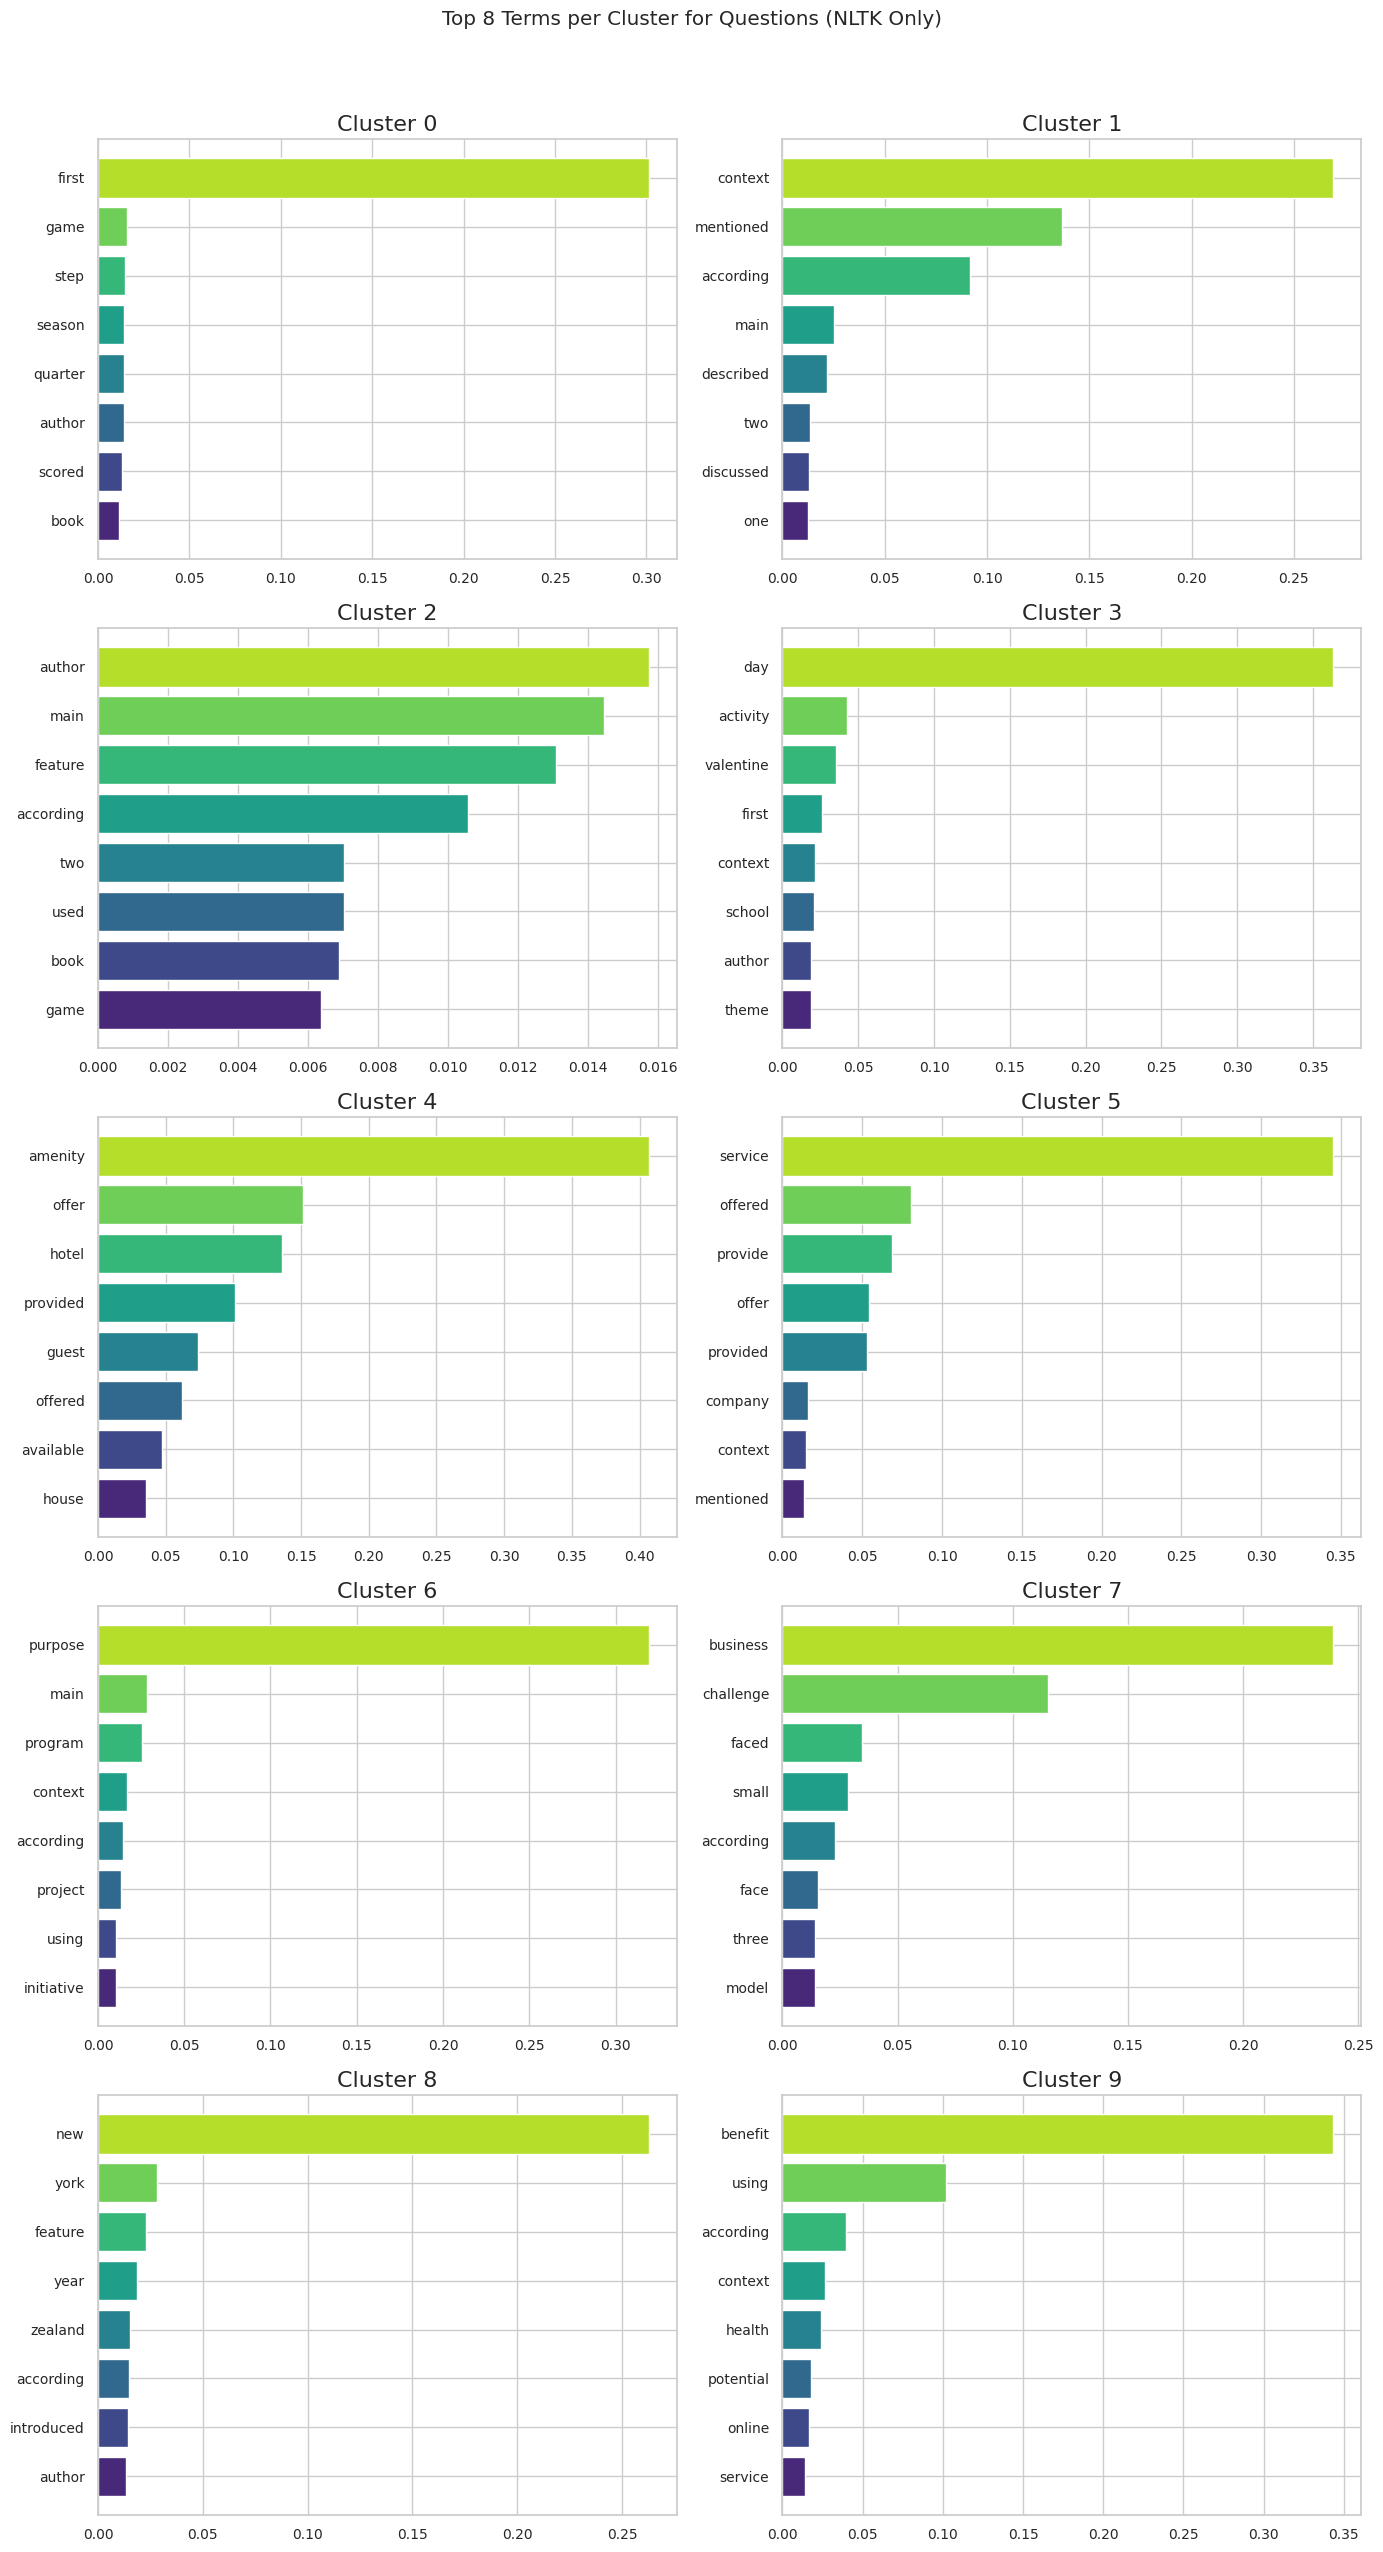


--- 3D SVD Interactive Visualization for Questions (NLTK Only) ---



Processing: Questions (Fully Processed) | Remove Corpus-Specific: True
[Preprocessing - Questions (Fully Processed)] Starting...
  Found corpus-specific stopwords: {'purpose', 'main', 'game', 'mentioned', 'feature', 'one', 'event', 'author', 'benefit', 'new', 'two', 'context', 'first', 'according', 'service'}
[Preprocessing - Questions (Fully Processed)] Done. 11987 docs remain.
[TF-IDF - Questions (Fully Processed)] Vectorizing...
  TF-IDF matrix shape: (11987, 4546)
[Optimal K - Questions (Fully Processed)] Finding optimal k...
  Optimal k = 10 (Score: 0.0069)


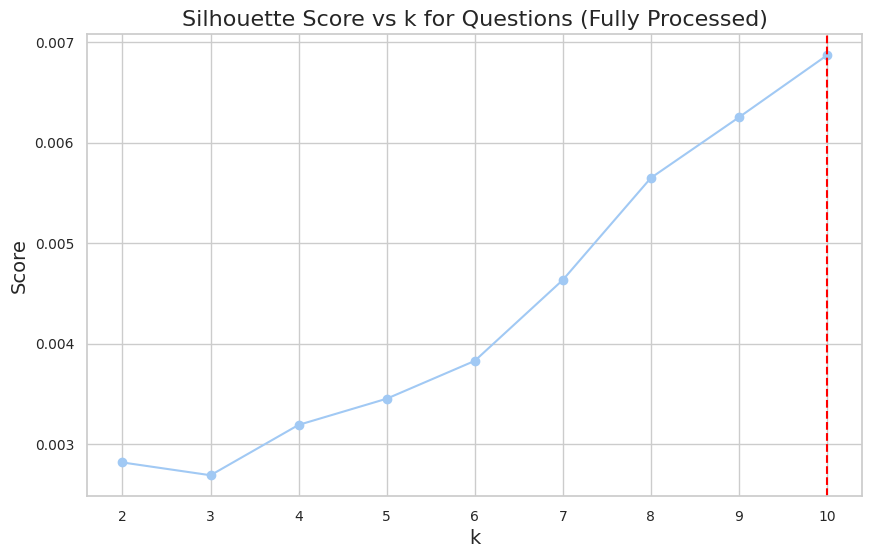

[K-Means - Questions (Fully Processed)] Clustering with k=10...
  Inertia: 11701.59

--- Top Terms per Cluster for Questions (Fully Processed) (k=10) ---
Cluster 0: book, role, type, used, three, year, using, program, offered, project
Cluster 1: challenge, faced, face, facing, winner, year, transitioning, global, consideration, dating
Cluster 2: function, website, system, crusher, software, content, primary, owns, using, body
Cluster 3: day, activity, valentine, school, theme, international, celebrated, planned, national, person
Cluster 4: step, online, dating, prepare, casino, take, using, involved, process, create
Cluster 5: offer, amenity, provided, hotel, guest, offered, available, house, facility, resort
Cluster 6: issue, key, focus, research, facing, address, user, area, work, solution
Cluster 7: character, movie, book, series, play, role, film, story, favorite, directed
Cluster 8: make, ingredient, recipe, needed, used, change, prepare, key, chicken, material
Cluster 9: unique, 

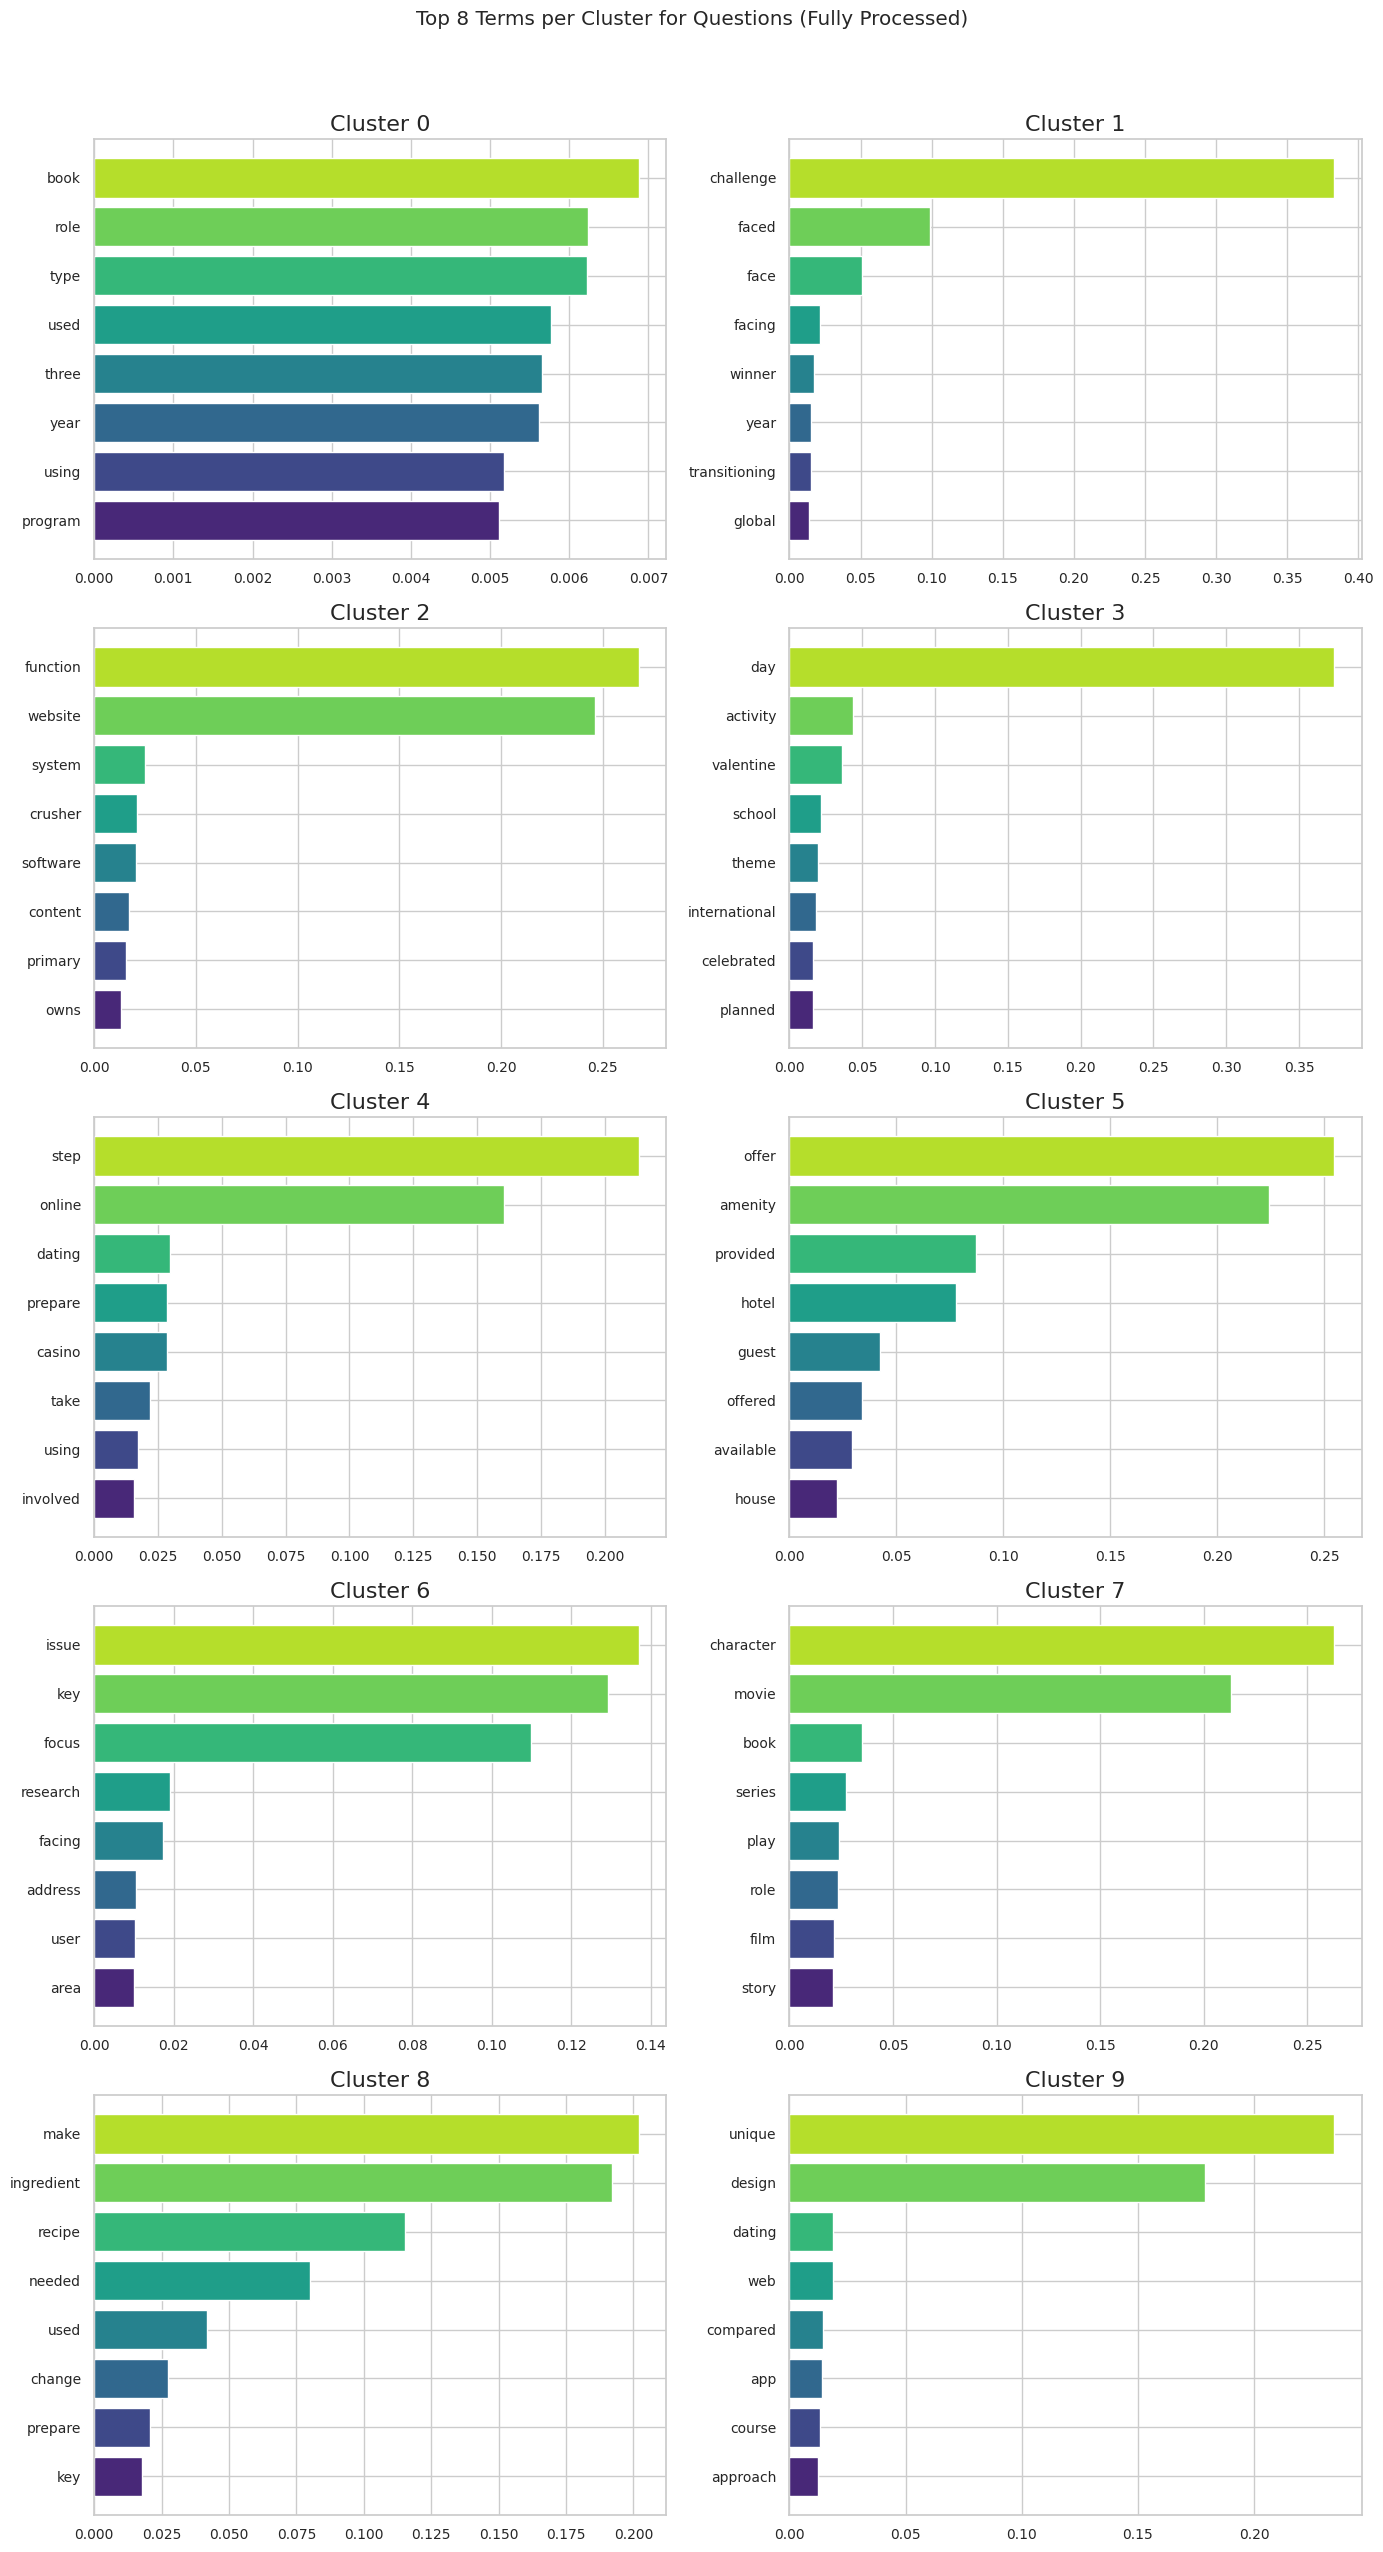


--- 3D SVD Interactive Visualization for Questions (Fully Processed) ---


In [ ]:
if dataset_hf:
    # NLTK stopwords only
    run_clustering_pipeline(dataset_hf['question'], "Questions (NLTK Only)", remove_corpus=False)
    # Fully processed
    run_clustering_pipeline(dataset_hf['question'], "Questions (Fully Processed)", remove_corpus=True)

else:
    print("Dataset not loaded")

## 7. Conclusion

Comparing clustering on minimally vs fully processed questions revealed that, when only standard stopwords were removed, the word **context** appeared among the most frequent. Upon closer inspection, we found many entries were simply requests like “explain me this context” which are irrelevant for our experiments. We therefore decided to filter out these instances to improve the quality of our results.
